In [1]:
import re
import glob
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk.collocations
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

Lendo cada um dos artigos e salvando em um dicionário

In [2]:
files = glob.glob("cozinhas/*")

docs = {}
for fname in files:
    with open(fname,'r') as f:
        key = fname.split('/')[-1]
        docs[key] = f.read()

Fazendo a limpeza das palavras em cada arquivo

In [3]:
sw = stopwords.words('english')

docs_ready = {}
for doc_name, words in docs.items():
    words = word_tokenize(words)
    words = [w.lower() for w in words if w.isalpha() and len(w) > 1]
    words = [w for w in words if w not in sw]
    
    docs_ready[doc_name] = words

Vamos concatenar todas as palavras para saber nosso corpus e a partir disso gerar nosso vocabulário

In [4]:
corpus = []
for words in docs_ready.values():
    corpus.extend(words)

# Vocabulário é formado pelos elementos unicos do corpus
# transformando em set tiramos as repetições
vocab = list(set(corpus))

print('Tamanho do corpus:', len(corpus))
print('Tamanho do vocabulario:', len(vocab))

Tamanho do corpus: 78913
Tamanho do vocabulario: 1743


Agora podemos montar nosso dataframe que vai guardar o Bag of Words. Vamos preecher com 0 por enquanto, logo veremos porque estamos fazendo isso.

In [5]:
doc_names = list(docs_ready.keys())
n_docs = len(doc_names)
n_words = len(vocab)

bow = pd.DataFrame(data=np.zeros((n_docs, n_words)), index=doc_names, columns=vocab)
bow.head()

feta  boil  mix  gold  hidden  tapioca  caesar  gyoza  udon  \
italian_742   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
mexican_481   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
mexican_497   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
italian_179   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
irish_44      0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   

             szechuan  ...  dog  kimchi  granules  coloring  dough  sambal  \
italian_742       0.0  ...  0.0     0.0       0.0       0.0    0.0     0.0   
mexican_481       0.0  ...  0.0     0.0       0.0       0.0    0.0     0.0   
mexican_497       0.0  ...  0.0     0.0       0.0       0.0    0.0     0.0   
italian_179       0.0  ...  0.0     0.0       0.0       0.0    0.0     0.0   
irish_44          0.0  ...  0.0     0.0       0.0       0.0    0.0     0.0   

             crock  breakfast  yakisoba  egg  
italian_742    0.0        0.0       0.0  0.0  
mexican_481    0.0        0.0       0.0  0.0  
mexican_497    0.0        0.0       0.0  0.0  
italian_179    0.0        0.0       0.0  0.0  
irish_44       0.0        0.0       0.0  0.0  

[5 rows x 1743 columns]

Pronto! Agora só falta preencher isso com a contagem em cada documento.

Vamos usar o Counter, que vem da biblioteca collections para fazer isso. Dada uma lista ele retorna um dicionário com as ocorrencias de cada elemento.

In [6]:
for doc_name, doc_words in docs_ready.items():
    # Fazendo a contagem
    words_count = Counter(doc_words)
    
    # Transformando em duas listas, uma com as palavras e outra com as contagens
    words = list(words_count.keys())
    count = list(words_count.values())
    
    # Acessando o documento especifico e colocando a contagem para cada palavra
    bow.loc[doc_name, words] = count

In [7]:
bow.head()

feta  boil  mix  gold  hidden  tapioca  caesar  gyoza  udon  \
italian_742   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
mexican_481   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
mexican_497   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
italian_179   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
irish_44      0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   

             szechuan  ...  dog  kimchi  granules  coloring  dough  sambal  \
italian_742       0.0  ...  0.0     0.0       0.0       0.0    0.0     0.0   
mexican_481       0.0  ...  0.0     0.0       0.0       0.0    0.0     0.0   
mexican_497       0.0  ...  0.0     0.0       0.0       0.0    0.0     0.0   
italian_179       0.0  ...  0.0     0.0       0.0       0.0    0.0     0.0   
irish_44          0.0  ...  0.0     0.0       0.0       0.0    0.0     0.0   

             crock  breakfast  yakisoba  egg  
italian_742    0.0        0.0       0.0  0.0  
mexican_481    0.0        0.0       0.0  0.0  
mexican_497    0.0        0.0       0.0  0.0  
italian_179    0.0        0.0       0.0  0.0  
irish_44       0.0        0.0       0.0  0.0  

[5 rows x 1743 columns]

In [8]:
bow.shape

(3979, 1743)

In [9]:
# Podemos ver se está certo vendo a soma de todas as entradas
print(bow.sum().sum())

78913.0


Excelente, agora temos uma tabela onde cada documento é representado por um vetor (cada linha da tabela). **O processo que aconteceu foi bem poderoso, transformamos dados não estruturados em dados estruturados que podemos fornecer aos algoritmos que conhecemos.**

Todos os diferentes arquivos, que a princípio eram só bytes, agora possuem uma representação numérica para cada documento. Então podemos usar esse espaço para entender melhor a relação entre esses arquivos.

Por exemplo, podemos ver qual arquivo tem as receitas mais parecidas com o *'italian_1'*. Para isso vamos usar a **distância de cosseno**.

$$ cos(\theta) = \frac{a \cdot b}{\rvert\rvert a \rvert\rvert \cdot \rvert\rvert b \rvert\rvert} $$

Mas a distancia de cosseno é dada por

$$ \text{dist} = 1 - \frac{a \cdot b}{\rvert\rvert a \rvert\rvert \cdot \rvert\rvert b \rvert\rvert}$$

Isso faz com que um vetor tenha distancia 0 para ele mesmo (já que é uma distancia). Dessa forma os valores da distancia de cosseno estão no intervalo $[0, 2]$. 

Visualmente temos o seguinte:

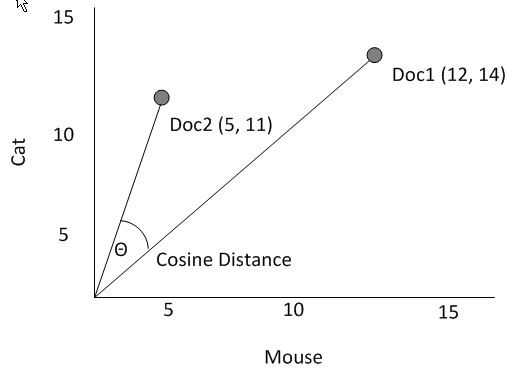

Veja mais aqui:
- https://www.machinelearningplus.com/nlp/cosine-similarity/
- https://en.wikipedia.org/wiki/Cosine_similarity

In [10]:
x_int = bow.loc['italian_1']

bow.apply(lambda x: cosine(x, x_int), axis=1).sort_values()

italian_1          0.000000
italian_394        0.422650
italian_448        0.422650
italian_132        0.438199
italian_38         0.439888
                     ...   
french_72          1.000000
mexican_631        1.000000
italian_516        1.000000
southern_us_217    1.000000
mexican_152        1.000000
Length: 3979, dtype: float64

Esse resultado é bem interessante, vamos fazer isso para cada uma das cozinhas.

In [11]:
# Pegando cada cozinha
cozinhas = [re.match(r'(.+)_\d+', c)[1] for c in bow.index]
cozinhas = list(set(cozinhas))

for cozinha in cozinhas:
    name = f'{cozinha}_1'
    x_int = bow.loc[name]
    similar = bow.apply(lambda x: cosine(x, x_int), axis=1).sort_values()
    print(name)
    for s in similar[1:6].index:
        print(f'  -{s}')

moroccan_1
  -greek_2
  -moroccan_10
  -italian_551
  -greek_127
  -italian_561
thai_1
  -thai_44
  -thai_98
  -thai_119
  -thai_109
  -thai_18
cajun_creole_1
  -italian_472
  -cajun_creole_135
  -southern_us_317
  -cajun_creole_136
  -cajun_creole_19
italian_1
  -italian_394
  -italian_448
  -italian_132
  -italian_38
  -italian_458
irish_1
  -italian_637
  -southern_us_267
  -cajun_creole_30
  -mexican_427
  -mexican_240
indian_1
  -indian_235
  -southern_us_329
  -jamaican_23
  -indian_33
  -irish_18
brazilian_1
  -french_244
  -british_93
  -russian_25
  -jamaican_38
  -southern_us_293
korean_1
  -korean_31
  -chinese_130
  -japanese_71
  -japanese_27
  -chinese_167
spanish_1
  -greek_87
  -italian_278
  -spanish_17
  -italian_783
  -spanish_53
mexican_1
  -italian_154
  -spanish_85
  -southern_us_364
  -mexican_472
  -mexican_448
chinese_1
  -chinese_231
  -irish_23
  -italian_632
  -moroccan_55
  -japanese_132
japanese_1
  -southern_us_87
  -italian_800
  -southern_us_86
  -india

No geral temos resultados bem interessantes

O importante que devemos perceber agora é que o que fizemos foi gerar um tabela, ou seja, dados estruturados para representar nossos arquivos. Então podemos lidar com ele assim como fizemos as tarefas na matéria de introdução a ciência de dados. Vamos ver se conseguimos classificar qual o pais dado o vetor do BoW.

In [12]:
df = bow.copy()
df.loc[:, 'cozinha'] = [re.match(r'(.+)_\d+', c)[1] for c in bow.index]
df.head()

feta  boil  mix  gold  hidden  tapioca  caesar  gyoza  udon  \
italian_742   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
mexican_481   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
mexican_497   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
italian_179   0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   
irish_44      0.0   0.0  0.0   0.0     0.0      0.0     0.0    0.0   0.0   

             szechuan  ...  kimchi  granules  coloring  dough  sambal  crock  \
italian_742       0.0  ...     0.0       0.0       0.0    0.0     0.0    0.0   
mexican_481       0.0  ...     0.0       0.0       0.0    0.0     0.0    0.0   
mexican_497       0.0  ...     0.0       0.0       0.0    0.0     0.0    0.0   
italian_179       0.0  ...     0.0       0.0       0.0    0.0     0.0    0.0   
irish_44          0.0  ...     0.0       0.0       0.0    0.0     0.0    0.0   

             breakfast  yakisoba  egg  cozinha  
italian_742        0.0       0.0  0.0  italian  
mexican_481        0.0       0.0  0.0  mexican  
mexican_497        0.0       0.0  0.0  mexican  
italian_179        0.0       0.0  0.0  italian  
irish_44           0.0       0.0  0.0    irish  

[5 rows x 1744 columns]

In [13]:
target = 'cozinha'
features = df.columns.to_list()
features.remove(target)

X, y = df[features], df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3183, 1743)
(796, 1743)
(3183,)
(796,)


In [14]:
clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [15]:
acc = accuracy_score(y_test, y_pred)
print(f'Acurácia: {acc:.4f}')

Acurácia: 0.6633
